In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)
del pmap['ggF-powheg']

In [3]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.2

year='2017'

In [4]:
indir = "outfiles/notrigger/maxchunks4/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()
if 'outfiles/notrigger/maxchunks4/2017bsm.coffea' in infiles:
    infiles.remove('outfiles/notrigger/maxchunks4/2017bsm.coffea')
if 'outfiles/notrigger/maxchunks4/2017data.coffea' in infiles:
    infiles.remove('outfiles/notrigger/maxchunks4/2017data.coffea')
outsum = processor.dict_accumulator()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)
    
started = 0
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum['templates'] = out['templates']
            outsum['sumw'] = out['sumw']
            started += 1
        else:
            outsum['templates'].add(out['templates'])
            outsum['sumw'].add(out['sumw'])
    
        del out

Loading outfiles/notrigger/maxchunks4/2017higgs.coffea
Loading outfiles/notrigger/maxchunks4/2017qcd.coffea
Loading outfiles/notrigger/maxchunks4/2017top.coffea
Loading outfiles/notrigger/maxchunks4/2017wandvv.coffea
Loading outfiles/notrigger/maxchunks4/2017z.coffea


In [5]:
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates'].scale(scale_lumi, 'dataset')

templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

In [17]:
h = templates.integrate('region','signal').sum('genflavor', 'pt1').integrate('ddb1',int_range=slice(0,0.64)) #.integrate('pt1',int_range=slice(1000,1200))

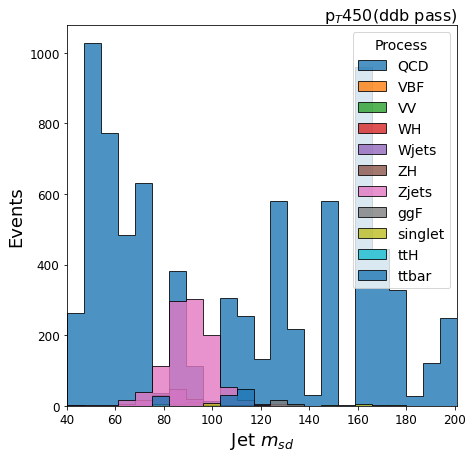

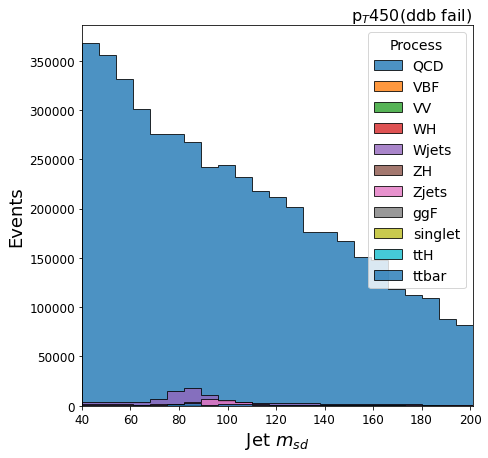

In [63]:
ddb_regions = ['pass', 'fail']

for ddb_region in ddb_regions:
        
    if ddb_region == 'pass':
        ddb_l = 0.64
        ddb_r = 1
    elif ddb_region == 'fail':
        ddb_l = 0
        ddb_r = 0.64 


    h_pt350 = templates.integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(350,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
    h_pt350_org = h_pt350.copy()
    h_pt450 = templates.integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(450,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
    h_pt450_org = h_pt450.copy()
    
    scale_process = {t[0]: -1 for t in templates.values().keys() if t[1] == 'signal'}

    h_pt450.scale(scale_process, 'process')
    
    h_diff = h_pt350.add(h_pt450)
    
      # make a nice ratio plot, adjusting some font sizes
    plt.rcParams.update({
            'font.size': 14,
            'axes.titlesize': 18,
            'axes.labelsize': 18,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12
        })
    fig, (ax) = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(7,7),
        #gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.07)

    # Here is an example of setting up a color cycler to color the various fill patches
    # We get the colors from this useful utility: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
    from cycler import cycler
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
    #ax.set_prop_cycle(cycler(color=colors))

    fill_opts = {
        'edgecolor': (0,0,0,0.3),
        'alpha': 0.8
    }
    error_opts = {
        'label': 'Stat. Unc.',
        'hatch': '///',
        'facecolor': 'none',
        'edgecolor': (0,0,0,.5),
        'linewidth': 0
    }
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }
  
    hist.plot1d(
            h_diff,
            overlay="process",
            ax=ax,
            clear=False,
            #stack=True,
            line_opts=None,
            fill_opts=fill_opts,
            error_opts=error_opts
        )
    
    ddb = plt.text(1., 1., r'p$_{T}$350-p$_{T}$450(ddb ' + ddb_region + ')',
                        fontsize=16,
                        horizontalalignment='right',
                        verticalalignment='bottom',
                        transform=ax.transAxes
                       )
    
    fig.savefig('plots/' + 'pT350-pT450_' + ddb_region + '.png')